In [50]:
import pandas as pd 
import matplotlib.pyplot as plt 
import requests
import math
from termcolor import colored as cl 
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import os

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout, Conv1D, Flatten, MaxPooling1D, Bidirectional

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "BTC.csv"))

In [4]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, df_y, series_days, input_hours, test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    forecast_series = df[-(series_days):].values # reducing our forecast series to last n days
    forecast_series_y = df_y[-(series_days):].values

    
    tr_X = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    tr_y = forecast_series_y[:-test_hours]
    ts_X = forecast_series[-test_hours:]
    ts_y = forecast_series_y[-test_hours:] # test data is the remaining test_hours

    
    train_X, train_y, test_X, test_y = [], [], [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, tr_X.shape[0]-input_hours, sample_gap): 
        train_X.append(tr_X[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(tr_y[i+input_hours]) # each y is just the next step after training sample

   # train_X = get_keras_format_series(train_X) # format our new training set to keras format
   # train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    for i in range(0, ts_X.shape[0]-input_hours): 
        test_X.append(ts_X[i:i+input_hours]) # each training sample is of length input hours
        test_y.append(ts_y[i+input_hours])

    train_X = np.stack(train_X)
    train_y = np.stack(train_y)
    test_X = np.stack(test_X)
    test_y = np.stack(test_y)
    test_X_close = ts_y
    
    return train_X, test_X, train_y, test_y, test_X_close

In [5]:
def unscale(arr):
    #arr = arr.reshape(-1, 1)
    #arr = np.concatenate((arr,arr,arr,arr),axis=1)
    arr = scaler.inverse_transform(arr)
    #arr = arr[:][:,0] 
    return arr


def plot_prediction(X, y, close):
    
    preds = model.predict(X)

    ts_X_unscale = unscale(close)
    pred_unscale = unscale(preds)
    ts_y_unscale = unscale(y)

    #start_range = range(1, test_X.shape[1]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X.shape[1], test_X.shape[1] + test_X.shape[0])  #predict range is going to be from end of X_init to length of test_hours


    #using our ranges we plot X_init
    plt.plot(ts_X_unscale)
    #and test and actual preds
    plt.plot(predict_range, ts_y_unscale, color='orange')
    plt.plot(predict_range, pred_unscale, color='teal', linestyle='--')

    plt.title('BTC')
    plt.legend(['Initial Series','Target Series','Predictions'])

In [6]:
def plot_cov_matrix(dataset):
    covMatrix = np.cov(np.rot90(dataset),bias=True)
    print(covMatrix.shape)
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    im = plt.imshow(covMatrix, cmap="gray")
    plt.colorbar(im)
    plt.show()

(4, 4)


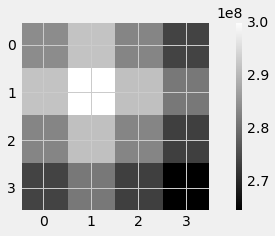

In [97]:
data = pd.read_csv(all_files[0])
scaler = MinMaxScaler()

plot_cov_matrix(data[['l', 'o', 'h', 'c']])

data[['c']]= scaler.fit_transform(data[['o']])

In [111]:
series_days = 256
input_hours = 30
test_hours = 40

train_X, test_X, train_y, test_y, test_X_close = (get_train_test_data(data[['c']], data[['c']], series_days, input_hours, test_hours))

In [103]:
print(test_y.shape)
print(test_X.shape)
print(train_y.shape)
print(train_X.shape)

(10, 1)
(10, 100, 1)
(16, 1)
(16, 100, 1)


In [104]:
def get_model(model_name):
    
    # initialize model
    model = Sequential() 
    
    if model_name == 'simpleRNN':
        
        # construct an RNN layer with specified number of hidden units
        # per cell and desired sequence input format 
        model.add(SimpleRNN(30, input_shape=(train_X.shape[1],train_X.shape[2])))

        # add an output layer to make final predictions 
        model.add(Dense(150, activation='relu'))
        model.add(Dense(1, activation='linear'))

        # define the loss function / optimization strategy, and fit
        # the model with the desired number of passes over the data (epochs) 
        model.compile(loss='mean_squared_error', optimizer='adam')
        
    elif model_name == 'bidirectionalLSTM':
    
        # First Layer
        model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(train_X.shape[1],train_X.shape[2])))
        model.add(Dropout(0.2))

        # Second Layer
        model.add(Bidirectional(LSTM(60, return_sequences=True)))
        model.add(Dropout(0.2))

        # Third Layer
        model.add(Bidirectional(LSTM(30, return_sequences=False)))

        model.add(Dense(units=1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
    elif model_name == 'simpleLSTM_with_hidden':
        
        model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
        model.add(Dropout(0.2))

        # second layer
        #model.add(LSTM(cell_units, return_sequences=False))
        #model.add(Dropout(0.2))

        # fourth layer and output
        model.add(Dense(100, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        

    elif model_name == 'LSTM_with_conv':
        
        # Conv part
        model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu',
                         input_shape=(train_X.shape[1], train_X.shape[2])))
        #model.add(MaxPooling1D(pool_size=4))

        model.add(LSTM(30))

        model.add(Dense(units=30, activation='relu'))
        model.add(Dense(1, activation='linear'))

        model.compile(optimizer='adam', loss='mean_squared_error')
        
    return model

In [81]:
def fit_model(train_X, train_y, test_X, test_y, epochs, model_type):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    model = get_model(model_type)    

    history = model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1, validation_split=0.2)
    
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Testing')
    plt.legend()
    plt.grid()

    return model



Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 0.3822 - val_loss: 0.4050
Epoch 2/300
1/1 [==============================] - 0s 36ms/step - loss: 0.2941 - val_loss: 0.3107
Epoch 3/300
1/1 [==============================] - 0s 57ms/step - loss: 0.2202 - val_loss: 0.2326
Epoch 4/300
1/1 [==============================] - 0s 45ms/step - loss: 0.1589 - val_loss: 0.1679
Epoch 5/300
1/1 [==============================] - 0s 38ms/step - loss: 0.1090 - val_loss: 0.1142
Epoch 6/300
1/1 [==============================] - 0s 41ms/step - loss: 0.0684 - val_loss: 0.0708
Epoch 7/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0376 - val_loss: 0.0385
Epoch 8/300
1/1 [==============================] - 0s 39ms/step - loss: 0.0170 - val_loss: 0.0178
Epoch 9/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0068 - val_loss: 0.0080
Epoch 10/300
1/1 [==============================] - 0s 38ms/step - loss: 0.0060 - val_loss: 0.0068
Epoch 11/300
1/1 [===

Epoch 84/300
1/1 [==============================] - 0s 34ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 85/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 86/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 87/300
1/1 [==============================] - 0s 42ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 88/300
1/1 [==============================] - 0s 48ms/step - loss: 0.0012 - val_loss: 0.0029
Epoch 89/300
1/1 [==============================] - 0s 49ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 90/300
1/1 [==============================] - 0s 60ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 91/300
1/1 [==============================] - 0s 50ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 92/300
1/1 [==============================] - 0s 41ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 93/300
1/1 [==============================] - 0s 35ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 94/3

1/1 [==============================] - 0s 43ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 167/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 168/300
1/1 [==============================] - 0s 43ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 169/300
1/1 [==============================] - 0s 34ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 170/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 171/300
1/1 [==============================] - 0s 37ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 172/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 173/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 174/300
1/1 [==============================] - 0s 33ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 175/300
1/1 [==============================] - 0s 36ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 176/300


1/1 [==============================] - 0s 38ms/step - loss: 9.3292e-04 - val_loss: 0.0021
Epoch 247/300
1/1 [==============================] - 0s 37ms/step - loss: 9.3144e-04 - val_loss: 0.0021
Epoch 248/300
1/1 [==============================] - 0s 36ms/step - loss: 9.2996e-04 - val_loss: 0.0021
Epoch 249/300
1/1 [==============================] - 0s 37ms/step - loss: 9.2849e-04 - val_loss: 0.0021
Epoch 250/300
1/1 [==============================] - 0s 34ms/step - loss: 9.2703e-04 - val_loss: 0.0021
Epoch 251/300
1/1 [==============================] - 0s 32ms/step - loss: 9.2556e-04 - val_loss: 0.0021
Epoch 252/300
1/1 [==============================] - 0s 35ms/step - loss: 9.2410e-04 - val_loss: 0.0021
Epoch 253/300
1/1 [==============================] - 0s 36ms/step - loss: 9.2265e-04 - val_loss: 0.0021
Epoch 254/300
1/1 [==============================] - 0s 34ms/step - loss: 9.2119e-04 - val_loss: 0.0021
Epoch 255/300
1/1 [==============================] - 0s 32ms/step - loss: 9.19

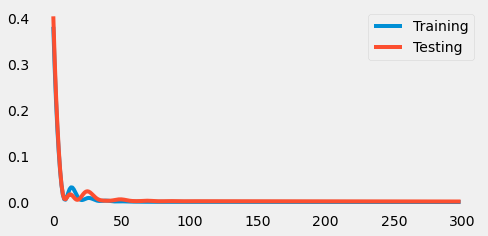

In [114]:
model = fit_model(train_X, train_y, test_X, test_y, 300, 'simpleRNN')

In [84]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 30)                960       
                                                                 
 dense_25 (Dense)            (None, 150)               4650      
                                                                 
 dense_26 (Dense)            (None, 1)                 151       
                                                                 
Total params: 5,761
Trainable params: 5,761
Non-trainable params: 0
_________________________________________________________________


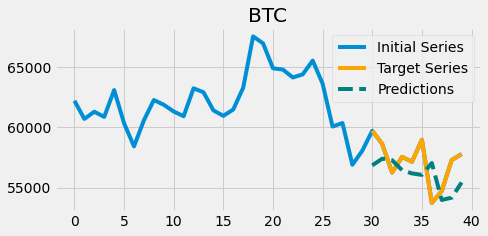

In [115]:
plot_prediction(test_X, test_y, test_X_close)

In [117]:
def fit_by_crypto(file_name,  scaler, pca, model, verbose=0):
    data = pd.read_csv(all_files[0])
    data2 = data
    
    data[['c']] = scaler.fit_transform(data[['c']])
    
    series_days = 256
    input_hours = 30
    test_hours = 40

    train_X, test_X, train_y, test_y, test_X_close = (get_train_test_data(data[['c']], data[['c']], series_days, input_hours, test_hours))
    
    
    data = data[['c']]
    temp = data[-input_hours:].values
    
    test_pred = []
    for test in test_X:
        test_pred.append(test)
    
    test_pred.append(temp)
    test_pred = np.stack(test_pred)
    
    #Yes, successive calls to fit will incrementally train the model.
    history = model.fit(train_X, train_y, epochs=300, batch_size=64, verbose=verbose, validation_split=0.1)
    
    print("validation loss :", history.history['val_loss'][-1])
    
    preds = model.predict(test_pred)
    
    today = train_y[-1]
    tommorow_pred = preds[-1]
    
    tommorow_price = unscale(tommorow_pred)
    
    ratio = 0
    if today > tommorow_pred:
        ratio = -(tommorow_pred / today)
    if today < tommorow_pred:
        ratio = today / tommorow_pred
    
    return ratio, tommorow_price

In [118]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "BTC.csv"))

scaler = StandardScaler()
pca = PCA(n_components=2)
model = get_model("simpleRNN")

for file in all_files:
    pred, price = fit_by_crypto(file, scaler, pca, model)
    print(pred)
    print(price)

validation loss : 0.04676908999681473
[-0.81701097]
[55591.934]
